In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt

In [4]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.54_pearson_0.6417.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [5]:
test_data = DataLoader(TestDataset(cfg), batch_size=512)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)
test_pc

0.7327945653435284

In [6]:
with h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]

prediction correlation: 
 [[1.         0.37771888 0.67148962 0.43815955 0.26113831]
 [0.37771888 1.         0.55390895 0.42751034 0.20364235]
 [0.67148962 0.55390895 1.         0.40872711 0.35340368]
 [0.43815955 0.42751034 0.40872711 1.         0.27804265]
 [0.26113831 0.20364235 0.35340368 0.27804265 1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged target prediction relative e

Text(0.5, 1.0, 'single trial target')

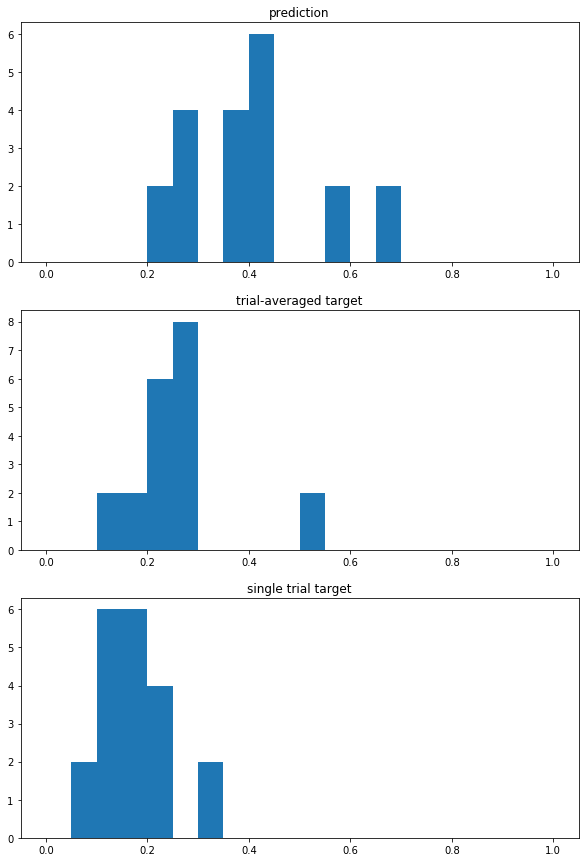

In [7]:
pred_corr, targ_corr, single_corr = correlation_matrix(pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [9]:
stim_corr = stimuli_corr_matrix(5, 5, single_trial)
noise_corr = single_corr - stim_corr
print('stimuli correlation: \n', stim_corr)
print('noise correlation: \n', noise_corr)
n_cells = 5
diagonal_idxs = list(range(0, n_cells*n_cells, n_cells+1))
mean_stim_corr = np.delete(stim_corr.flatten(), diagonal_idxs).mean()
mean_noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs).mean()
print(mean_stim_corr, mean_noise_corr)

stimuli correlation: 
 [[0.67177597 0.11595256 0.2977213  0.22079329 0.15485661]
 [0.11595256 0.35368846 0.13764053 0.16512185 0.08163705]
 [0.2977213  0.13764053 0.34117301 0.14615804 0.1148277 ]
 [0.22079329 0.16512185 0.14615804 0.68809142 0.20296255]
 [0.15485661 0.08163705 0.1148277  0.20296255 0.61850253]]
noise correlation: 
 [[ 0.32822403  0.00981137  0.04666152 -0.00221707  0.01566952]
 [ 0.00981137  0.64631154  0.0289137   0.01481814  0.0088896 ]
 [ 0.04666152  0.0289137   0.65882699 -0.01002382  0.00490734]
 [-0.00221707  0.01481814 -0.01002382  0.31190858  0.00953964]
 [ 0.01566952  0.0088896   0.00490734  0.00953964  0.38149747]]
0.16376714910437626 0.012696993584019984


In [8]:
Fano(single_trial)

0.09103926791651518

prediction correlation: 
 [[ 1.         -0.00835926  0.00676478  0.02139853  0.02643943]
 [-0.00835926  1.         -0.00703164  0.00452798  0.01574806]
 [ 0.00676478 -0.00703164  1.          0.02921365 -0.00737698]
 [ 0.02139853  0.00452798  0.02921365  1.          0.01888876]
 [ 0.02643943  0.01574806 -0.00737698  0.01888876  1.        ]]
trial-averaged correlation: 
 [[1.         0.1924971  0.51967268 0.29261007 0.21739408]
 [0.1924971  1.         0.29852532 0.27960452 0.14421011]
 [0.51967268 0.29852532 1.         0.24257533 0.2031594 ]
 [0.29261007 0.27960452 0.24257533 1.         0.2817152 ]
 [0.21739408 0.14421011 0.2031594  0.2817152  1.        ]]
single trial correlation: 
 [[1.         0.12576394 0.34438281 0.21857622 0.17052613]
 [0.12576394 1.         0.16655423 0.17993999 0.09052665]
 [0.34438281 0.16655423 1.         0.13613422 0.11973504]
 [0.21857622 0.17993999 0.13613422 1.         0.21250219]
 [0.17052613 0.09052665 0.11973504 0.21250219 1.        ]]
trial-averaged tar

Text(0.5, 1.0, 'single trial target')

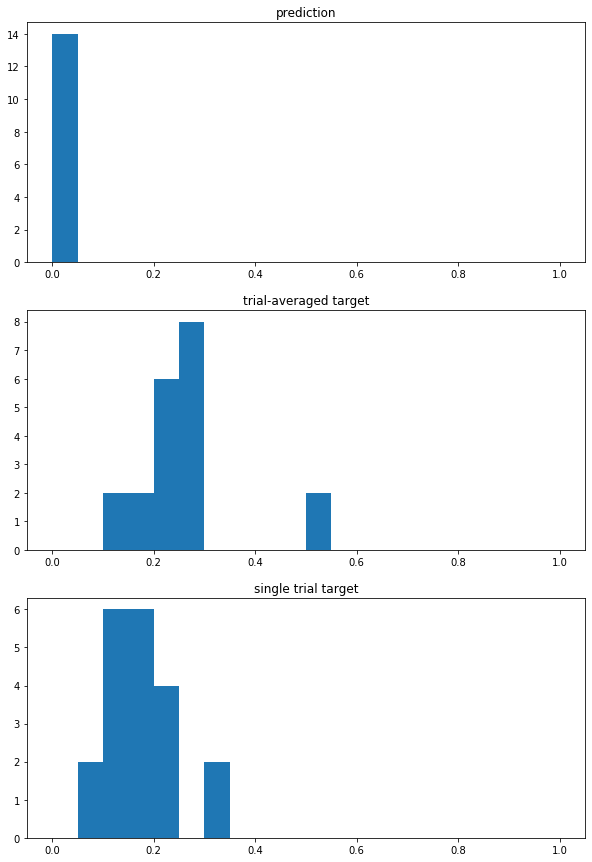

In [127]:
with torch.no_grad():
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = model.bipolar(x)
        out = model.amacrine(out)
        out = 100*torch.poisson(0.01*model.ganglion(out))
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
#pred_corr, targ_corr = correlation_matrix(val_pred, val_targ, binary=True, thre=2)
pred_corr, targ_corr, single_corr = correlation_matrix(val_pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [128]:
pearsons = []
for cell in range(5):
    pearsons.append(pearsonr(val_pred[:,cell],target[:,cell])[0])
print('trial-averged vs prediction:', np.array(pearsons).mean())
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],target[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('trial-averged vs single-trial:', np.array(mean_r).mean())
mean_r = []
for trial in range(5):
    pearsons = []
    for cell in range(5):
        pearsons.append(pearsonr(single_trial[trial,:,cell],val_pred[:,cell])[0])
    mean_r.append(np.array(pearsons).mean())
print('single-trial vs prediction:', np.array(mean_r).mean())

trial-averged vs prediction: 0.10045079837291668
trial-averged vs single-trial: 0.7875977724261742
single-trial vs prediction: 0.08025481102764315


0.01 0.20509653710359732 0.1542425768248346 0.7864825 0.02408654676720519 0.14805431902585028
0.1 0.2294773631160418 0.25724495068492126 0.17557177 0.025365709898993616 0.05323456586172657
0.2 0.21853107500259458 0.3319647855880895 0.1211735 0.028146830000644142 0.055121645135997474
0.3 0.20107156324960526 0.4040707848501571 0.09805695 0.04352176200214594 0.04719256884599223
0.4 0.17938281459642502 0.4629385643416488 0.082457736 0.05897136714870893 0.04099243729979188
0.5 0.15544478418603092 0.4930053790194585 0.07320485 0.06681605508913317 0.043811240514033956
0.6 0.14606849143133716 0.5202138733438283 0.06506396 0.0729023007801887 0.04403408443294202
0.7 0.12807703652597652 0.5377265458401869 0.059157595 0.08778796995315685 0.039144919067526554
0.8 0.12001087882118874 0.5658606728642059 0.054144766 0.09981692830120382 0.03674404274427834
0.9 0.09824429679726435 0.5785661875738796 0.05001143 0.11611538426219185 0.039543128603430115
1.0 0.09866746296458442 0.5861349797278338 0.04618977

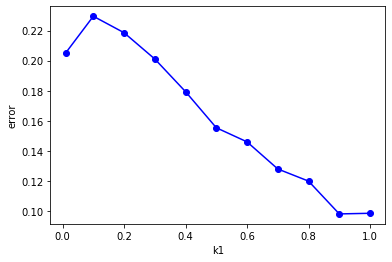

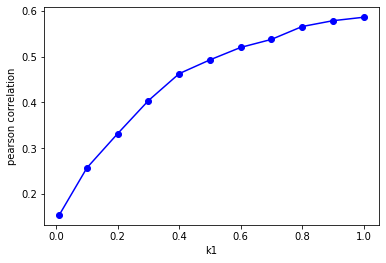

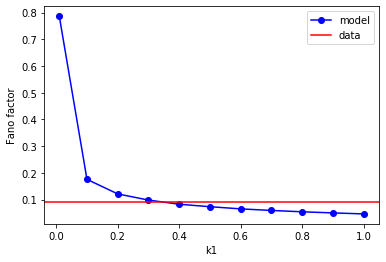

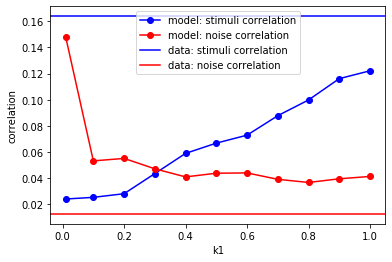

In [28]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k1_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k1 in k1_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[k1, None, None])
    print(k1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k1', k1_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.01 0.2848979234833435 0.48577678519335005 0.79298925 0.050217976866726445 0.004747417129641819
0.05 0.07701258403954409 0.6307610345116519 0.16140132 0.15378244084084447 -0.0010714084736047895
0.1 0.12473116762249846 0.6881510913711866 0.07936363 0.22651025189685497 -0.002785208447257348
0.2 0.26699940574047193 0.7104812015759239 0.039591774 0.29040591686753287 -7.610151171533048e-05
0.3 0.32032389328637856 0.7151538919952681 0.026840722 0.3142168252873534 -0.0011460280659727651
0.4 0.3543158293628374 0.7238455875395363 0.020020405 0.3287292168892451 -0.001162077790698876
0.5 0.3948946655394728 0.7213358074811056 0.015956106 0.3447087189799901 0.00016383869991784956


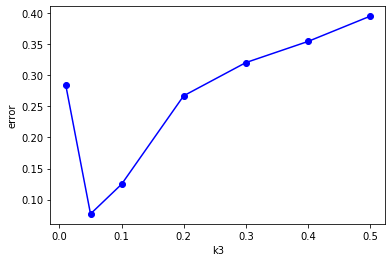

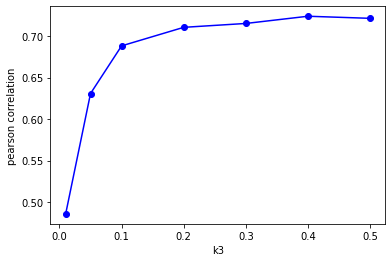

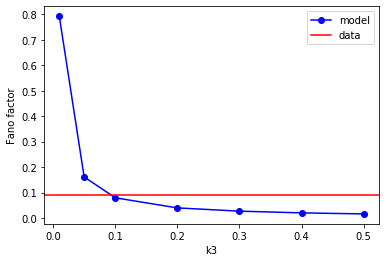

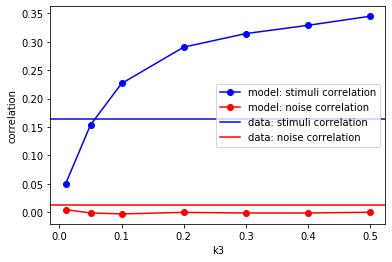

In [29]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k3_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k3 in k3_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[None, None, k3])
    print(k3, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k3', k3_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.01 0.13289999556844334 0.22790723613307273 0.3908519 0.02901936746297933 0.17160372225524015
0.1 0.12789467625666798 0.4473981806140741 0.12590575 0.071041513397518 0.06590968214985794
0.2 0.085166922755721 0.5340880055443994 0.087745644 0.1061234415535193 0.06020146788490852
0.3 0.07239970416517534 0.5730458124561508 0.069869325 0.12638988243887378 0.04976171850114711
0.4 0.06803981209730432 0.5974286335073534 0.058779504 0.15094912212378417 0.042416377339339735
0.5 0.10709870567284915 0.6181073388934689 0.050567664 0.17892751788209788 0.03916878302276508
0.6 0.1279828272982506 0.6474549973593302 0.0448697 0.18528944542062276 0.04047285206962111
0.7 0.17217607313387276 0.6561962659402678 0.040744618 0.2098044284532476 0.03890682060115701
0.8 0.18056773380897012 0.6688915139877196 0.03703527 0.2153936868089635 0.03807611967546124
0.9 0.18936245014044972 0.6684225362062018 0.034289595 0.22504674250819418 0.031940002193502556
1.0 0.24020824367535984 0.67205489399843 0.03169032 0.249026

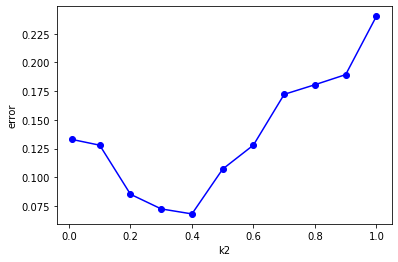

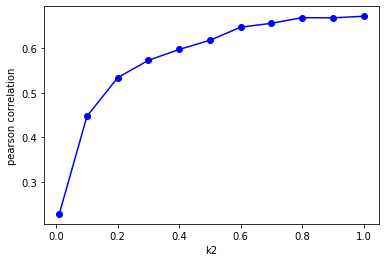

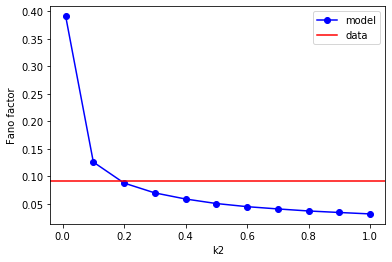

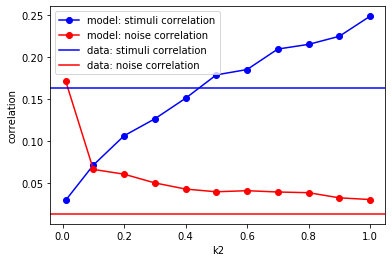

In [30]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
k2_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for k2 in k2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, poisson=[None, k2, None])
    print(k2, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('k2', k2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

0.0 0.518003694603513 0.7327945669340944 9.00017e-18 0.39737414421690476 -3.8857805861880476e-17 0.9999999921920592
0.1 0.48812671738742297 0.731387368986134 0.0023970564 0.3829097928509049 0.0017228918914192232 0.9753354686174786
0.2 0.35323996363518617 0.7076407445489503 0.011293105 0.3181837346668474 0.008924586276508197 1.1940705894630872
0.3 0.1474742880613219 0.6657447597524934 0.024164855 0.21780475989525944 0.019153088018325652 1.4604460897152576
0.4 0.06802439545041128 0.5953837695040718 0.038159415 0.1353293506972808 0.030060137911263336 1.6387868038389428
0.5 0.15343195964202616 0.5251531333059687 0.05213019 0.07490016953681368 0.036130744021845726 1.731374610554799
0.6 0.21005488047163215 0.44162318737232037 0.06616831 0.04777144032976978 0.03911182784077881 1.7927522859831653
0.7 0.243457334659019 0.38485802156670623 0.07999498 0.030691016228026245 0.04194730295381001 1.8313944099329638
0.8 0.26098992350686423 0.3331614394465988 0.09312298 0.02037338989297916 0.04478790881

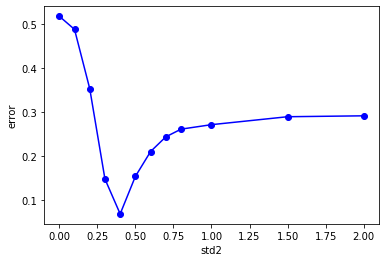

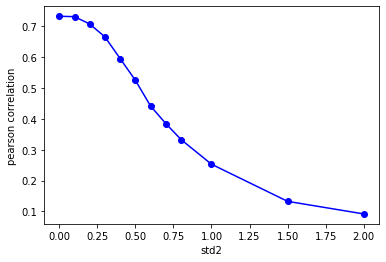

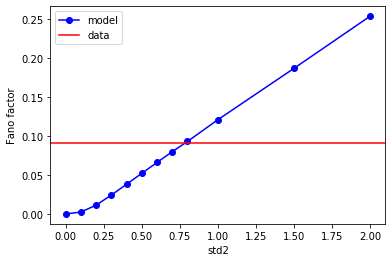

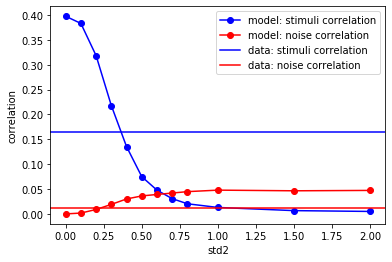

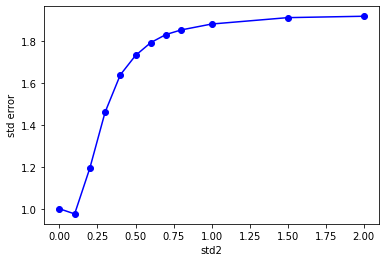

In [44]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, gaussian=[0, 0, std2, 0])
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

In [26]:
pred_single_trial = []
for n in range(5):
    val_pred = []
    val_targ = []
    for x,y in test_data:
        x = x.to(device)
        out = noise_model(x, model, device)
        val_pred.append(out.detach().cpu().numpy())
        val_targ.append(y.detach().numpy())
    val_pred = np.concatenate(val_pred, axis=0)
    val_targ = np.concatenate(val_targ, axis=0)
    pred_single_trial.append(val_pred)
pred_single_trial = np.stack(pred_single_trial)

In [30]:
pearson_std = Pearsonr_std(single_trial, pred_single_trial, 5)

In [32]:
from scipy.stats import pearsonr
pearsonr(pred_single_trial.std(0)[:,0], single_trial.std(0)[:,0])

(0.19531870082507863, 2.712354828985242e-52)

In [38]:
single_trial.std(0)[:,0].max()

49.244745528737965

0.0 0.518003694603513 0.7327945669340944 9.00017e-18 0.39737414421690476 -3.8857805861880476e-17
0.1 0.5109503891920574 0.7168488714295862 0.0029671835 0.3900727781973692 0.004293384174119642
0.2 0.41370137600025453 0.6438570690389127 0.01130361 0.32711840481523063 0.014777008875273168
0.3 0.2718490546451927 0.539640515947971 0.022725333 0.21564951511240116 0.02839940668068695
0.4 0.13514998872733355 0.44077550617174194 0.03360107 0.1169463146648722 0.047801666020160775
0.5 0.1525469438131845 0.34159670519603474 0.04387221 0.05751745237949054 0.053945771562664724
0.6 0.20331612255648943 0.25953871533464684 0.053461418 0.029753889363093138 0.06000321742452143
0.7 0.2359339287959449 0.18924545838427026 0.06207054 0.015855666498160708 0.05999111551516827
0.8 0.2525754661980577 0.15141191056894826 0.07147087 0.007668765687637613 0.06108099734448243
1.0 0.2644616895066523 0.10301230924321347 0.08807212 0.0038175403994237583 0.05986317459959366
1.5 0.2613633999161338 0.03425689576654127 0.13

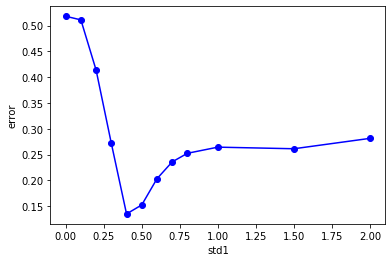

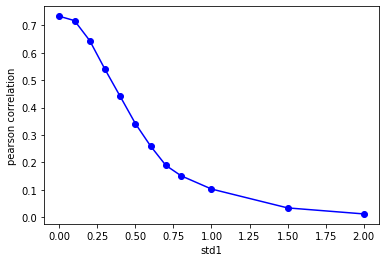

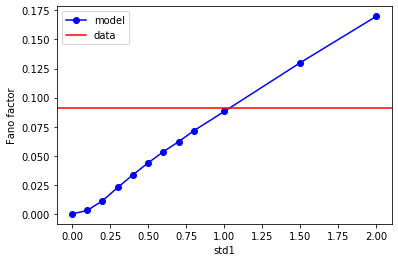

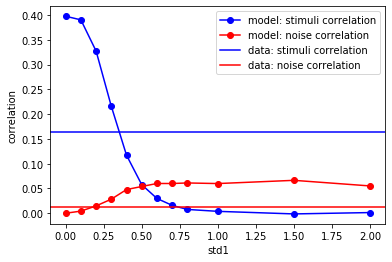

In [32]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std1_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for std1 in std1_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, gaussian=[0, std1, 0, 0])
    print(std1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('std1', std1_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

2.0 0.518003694603513 0.7327945669340944 9.00017e-18 0.39737414421690476 -3.8857805861880476e-17
2.0 0.5179367460333784 0.732878540246058 2.1385033e-05 0.39734368189877356 1.91115356439342e-06
2.0 0.515636064852179 0.7326067798194404 8.6479085e-05 0.3963669109261482 -2.4759013497632766e-06
2.0 0.5135527664781753 0.7329605512064326 0.00019672267 0.39548207624022164 -6.093270456763999e-06
2.0 0.5113833533308031 0.732738339253236 0.00055771443 0.394533241727396 1.7564324337804305e-05
2.0 0.48350674440030067 0.7327217447645984 0.0023635726 0.3826983293071666 -3.589738403911996e-05
2.0 0.29991186089989047 0.7131418621476948 0.015154376 0.305162679721282 -0.0007968823921329874
2.0 0.07982743963527944 0.6331729495575782 0.045422245 0.1559140183502646 0.0017474650010119303


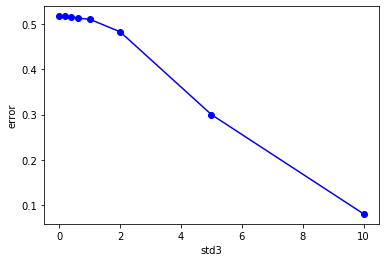

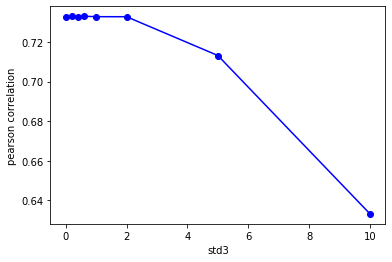

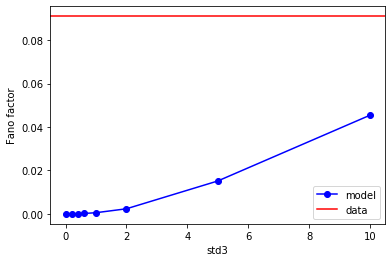

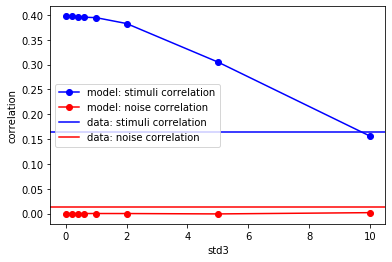

In [33]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std3_list = [0., 0.2, 0.4, 0.6, 1.0, 2.0, 5.0, 10.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
for std3 in std3_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr = Noises(model, test_data, single_corr, device, gaussian=[0, 0, 0, std3])
    print(std1, error, accuracy, fano, mean_stim_corr, mean_noise_corr)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
single_noise_plot('std3', std3_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list)

In [12]:
noise = single_trial - single_trial.mean(0)

In [41]:
((np.expand_dims(noise, -1)*np.expand_dims(noise, -2)).mean(-3)/np.expand_dims(single_trial.std(-2), -1)/np.expand_dims(single_trial.std(-2), -2)).mean(0)

array([[ 0.29584495,  0.00826199,  0.03653543,  0.00508418,  0.01701765],
       [ 0.00826199,  0.52177238,  0.02155001,  0.01332253,  0.00614495],
       [ 0.03653543,  0.02155001,  0.53797438, -0.00956078,  0.0023857 ],
       [ 0.00508418,  0.01332253, -0.00956078,  0.26557859,  0.01017555],
       [ 0.01701765,  0.00614495,  0.0023857 ,  0.01017555,  0.32026671]])

In [9]:
n_cells = 5
with torch.no_grad():
    pred_corr = []
    pred_single_trial = []
    for n in range(10):
        val_pred = []
        val_targ = []
        for x,y in test_data:
            x = x.to(device)
            out = noise_model(x, model, device, gaussian=[0, 0, 0.4, 0])
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        pred_corr.append(corr_matrix(n_cells, val_pred))
        pred_single_trial.append(val_pred)
    pred_corr = np.stack(pred_corr).mean(axis=0)
    pred_single_trial = np.stack(pred_single_trial)

In [10]:
pred_noise  = pred_single_trial - pred_single_trial.mean(0)
pred_noise_corr = ((np.expand_dims(pred_noise, -1)*np.expand_dims(pred_noise, -2)).mean(-3)/np.expand_dims(pred_single_trial.std(-2), -1)/np.expand_dims(pred_single_trial.std(-2), -2)).mean(0)

In [12]:
stim_corr = stimuli_corr_matrix(5, 10, pred_single_trial)
noise_corr = pred_corr - stim_corr
noise_corr

array([[0.42560329, 0.02373649, 0.0785136 , 0.01247255, 0.01157733],
       [0.02373649, 0.75589733, 0.06645303, 0.01662405, 0.00169704],
       [0.0785136 , 0.06645303, 0.76289535, 0.02664816, 0.0067447 ],
       [0.01247255, 0.01662405, 0.02664816, 0.39418117, 0.01570011],
       [0.01157733, 0.00169704, 0.0067447 , 0.01570011, 0.48441891]])

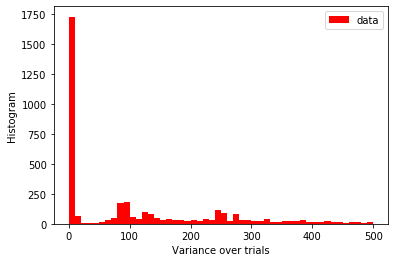

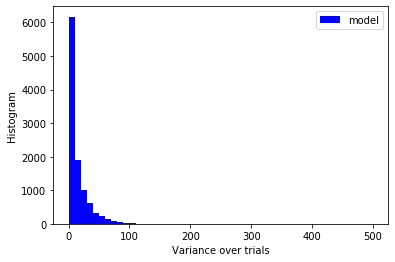

In [20]:
zero_idx = np.where(single_trial.flatten() == 0)[0]
plt.hist(np.delete(noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='r', label='data')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial.flatten() < 0.69)[0]
plt.hist(np.delete(pred_noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='b', label='model')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.legend()
plt.show()

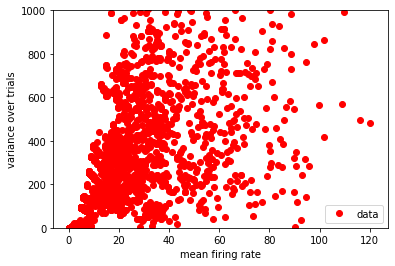

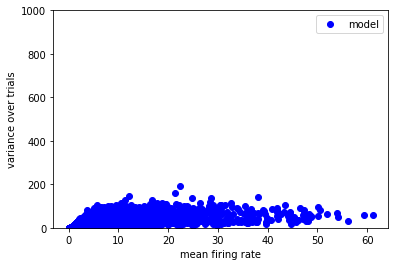

In [21]:
plt.plot(single_trial.mean(0).flatten(), noise.var(0).flatten(), 'ro', label='data')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()
plt.plot(pred_single_trial.mean(0).flatten(), pred_noise.var(0).flatten(), 'bo', label='model')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()

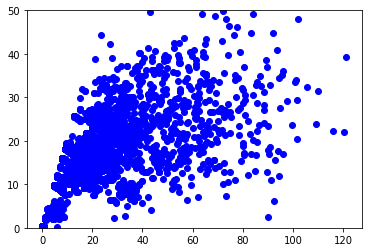

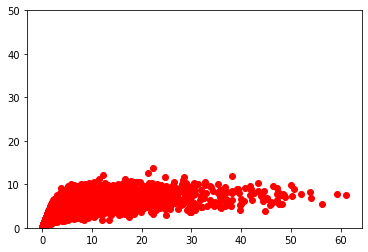

In [15]:
plt.plot(single_trial.mean(0).flatten(), noise.std(0).flatten(), 'bo')
plt.ylim(0, 50)
plt.show()
plt.plot(pred_single_trial.mean(0).flatten(), pred_noise.std(0).flatten(), 'ro')
plt.ylim(0, 50)
plt.show()

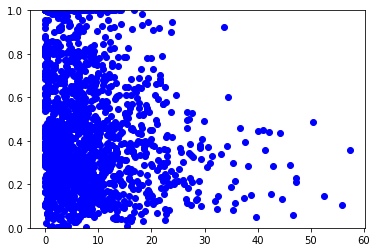

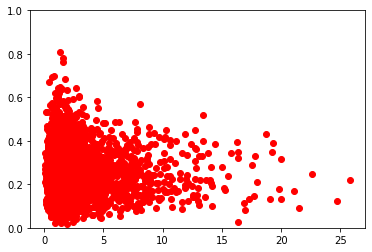

In [53]:
corr_noise = np.nanmean((np.expand_dims(noise, -1)*np.expand_dims(noise, -2)).mean(0)/np.expand_dims(noise.std(0), -1)/np.expand_dims(noise.std(0), -2), (-1,-2))
plt.plot(single_trial.mean((0,2)), corr_noise, 'bo')
plt.ylim(0, 1)
plt.show()
pred_corr_noise = np.nanmean((np.expand_dims(pred_noise, -1)*np.expand_dims(pred_noise, -2)).mean(0)/np.expand_dims(pred_noise.std(0), -1)/np.expand_dims(pred_noise.std(0), -2), (-1,-2))
plt.plot(pred_single_trial.mean((0,2)), pred_corr_noise, 'ro')
plt.ylim(0, 1)
plt.show()

In [66]:
with torch.no_grad():
    pred_corr = []
    pred_single_trial = []
    for n in range(10):
        val_pred = []
        val_targ = []
        for x,y in test_data:
            x = x.to(device)
            out = noise_model(x, model, device, poisson=[None, 0.4, None])
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        pred_corr.append(corr_matrix(n_cells, val_pred))
        pred_single_trial.append(val_pred)
    pred_corr = np.stack(pred_corr).mean(axis=0)
    pred_single_trial = np.stack(pred_single_trial)

In [67]:
pred_noise  = pred_single_trial - pred_single_trial.mean(0)

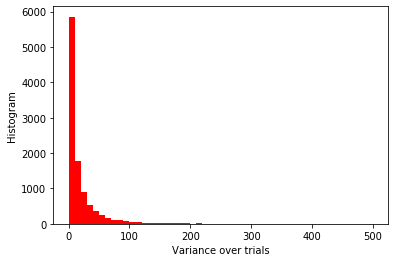

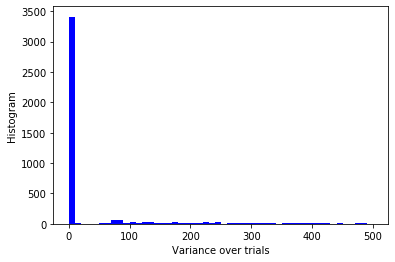

In [68]:
zero_idx = np.where(pred_single_trial.flatten() < 0.69)[0]
plt.hist(np.delete(pred_noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='r')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.show()
zero_idx = np.where(single_trial.flatten() == 0)[0]
plt.hist(np.delete(noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='b')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.show()

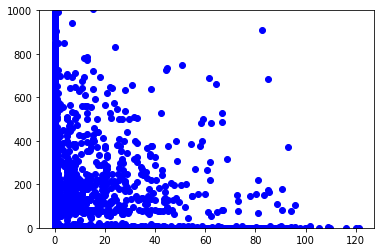

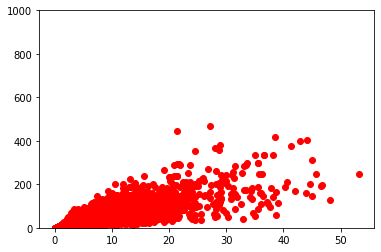

In [70]:
plt.plot(single_trial.mean(0).flatten(), noise.var(0).flatten(), 'ro', label='data')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()
plt.plot(pred_single_trial.mean(0).flatten(), pred_noise.var(0).flatten(), 'bo', label='model')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()

In [13]:
n_cells = 5
with torch.no_grad():
    pred_corr = []
    pred_single_trial = []
    for n in range(5):
        val_pred = []
        val_targ = []
        for x,y in test_data:
            x = x.to(device)
            out = noise_model(x, model, device, poisson=[None, None, 0.1], gaussian=[0, 0, 0.18, 0])
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        pred_corr.append(corr_matrix(n_cells, val_pred))
        pred_single_trial.append(val_pred)
    pred_corr = np.stack(pred_corr).mean(axis=0)
    pred_single_trial = np.stack(pred_single_trial)

In [14]:
single_trial_corr_matrix(5, 5, pred_single_trial)

array([[1.        , 0.1603855 , 0.30490637, 0.26973013, 0.15673813],
       [0.1603855 , 1.        , 0.16508678, 0.16853667, 0.09959801],
       [0.30490637, 0.16508678, 1.        , 0.19162919, 0.12907285],
       [0.26973013, 0.16853667, 0.19162919, 1.        , 0.12887153],
       [0.15673813, 0.09959801, 0.12907285, 0.12887153, 1.        ]])

In [9]:
error, _, fano, _, _, _ = Noises(model, test_data, single_corr, single_trial, device, poisson=[None, None, 0.1], gaussian=[0, 0, 0.18, 0])
error

0.08388695330057258

In [10]:
fano

0.090069555

In [15]:
Fano(pred_single_trial)

0.090578504

In [23]:
pred_noise  = pred_single_trial - pred_single_trial.mean(0)

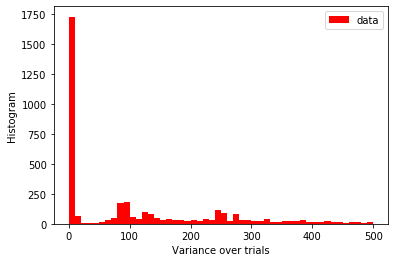

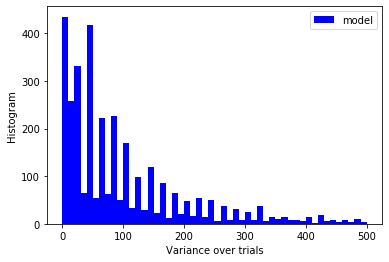

In [24]:
zero_idx = np.where(single_trial.flatten() == 0)[0]
plt.hist(np.delete(noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='r', label='data')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial.flatten() < 0.69)[0]
plt.hist(np.delete(pred_noise.var(0).flatten(), zero_idx), bins=50, range=(0,500), color='b', label='model')
plt.xlabel('Variance over trials')
plt.ylabel('Histogram')
plt.legend()
plt.show()

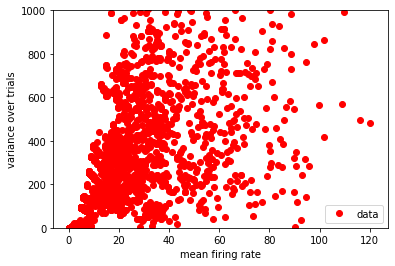

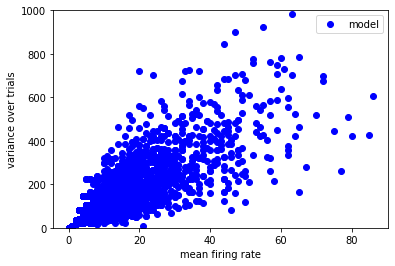

In [25]:
plt.plot(single_trial.mean(0).flatten(), noise.var(0).flatten(), 'ro', label='data')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()
plt.plot(pred_single_trial.mean(0).flatten(), pred_noise.var(0).flatten(), 'bo', label='model')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()

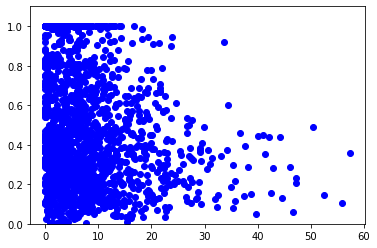

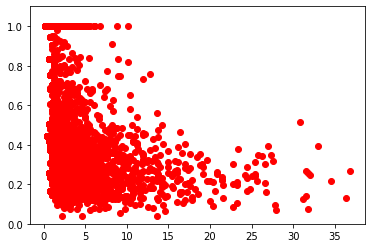

In [44]:
corr_noise = np.nanmean((np.expand_dims(noise, -1)*np.expand_dims(noise, -2)).mean(0)/np.expand_dims(noise.std(0), -1)/np.expand_dims(noise.std(0), -2), (-1,-2))
plt.plot(single_trial.mean((0,2)), corr_noise, 'bo')
plt.ylim(0, 1.1)
plt.show()
pred_corr_noise = np.nanmean((np.expand_dims(pred_noise, -1)*np.expand_dims(pred_noise, -2)).mean(0)/np.expand_dims(pred_noise.std(0), -1)/np.expand_dims(pred_noise.std(0), -2), (-1,-2))
plt.plot(pred_single_trial.mean((0,2)), pred_corr_noise, 'ro')
plt.ylim(0, 1.1)
plt.show()

0.0 0.14378749996024973 0.6878463942065735 0.08025889 0.2281920830501714 -0.0019810617190757955 0.8817178460421196
0.05 0.13318702645643407 0.6771278554433948 0.081330724 0.22820770033230997 -0.0011939502189308089 0.8885696669859334
0.1 0.10793606069601096 0.6823035799579167 0.083592325 0.20534932005334822 0.0031239131772548305 0.9438382613006386
0.15 0.0793359881756484 0.6592057451598661 0.08791097 0.20040309402028847 0.001463143998714367 1.0932863572637488
0.2 0.06032363906858839 0.6388578739009256 0.09302845 0.1720725543019377 0.004582153895465525 1.2631559910342378
0.25 0.08380413356117399 0.6265767627121284 0.09733206 0.13590926149840768 0.007233642733331365 1.4418263110602165
0.3 0.1333399172465001 0.5887091978445901 0.10348088 0.11135531268855434 0.00824413650517181 1.601715888636187
0.35 0.18522821959328273 0.5524581037608196 0.10913369 0.08864715275428978 0.00882379606355945 1.7241307026322215
0.4 0.21597682501948576 0.5049410941788393 0.11564712 0.07089428478609744 0.01346348

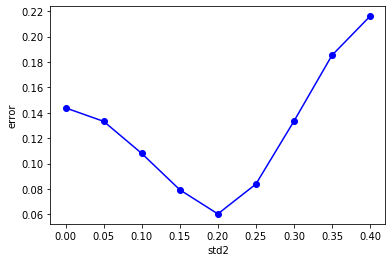

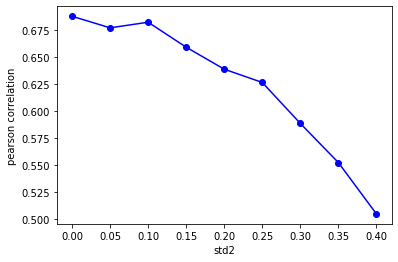

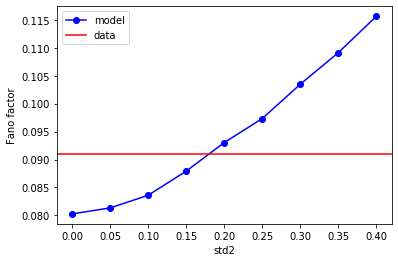

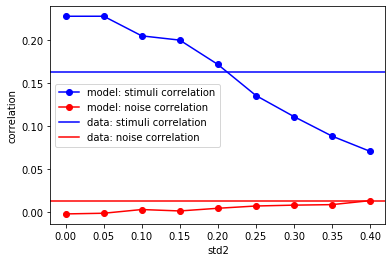

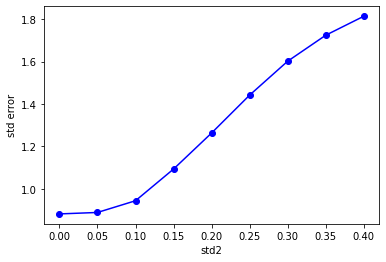

In [10]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, poisson=[None, None, 0.1], gaussian=[0, 0, std2, 0])
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

In [15]:
total_error = []
for k3 in np.arange(0.02,0.22,0.02):
    for std2 in np.arange(0.1,0.3,0.02):
        error, _, fano, _, _, _ = Noises(model, test_data, single_corr, single_trial, device, poisson=[None, None, k3], gaussian=[0, 0, std2, 0])
        fano_error = abs(fano - 0.091) / 0.091
        print(k3, std2, error, fano_error, error + fano_error)
        total_error.append(error + fano_error)
total_error = np.array(total_error).reshape((10, 10))

0.02 0.1 0.2190897393346314 3.3667617079975845 3.585851447332216
0.02 0.12000000000000001 0.2123741373130022 3.4307063569079395 3.643080494220942
0.02 0.14 0.24397602322717699 3.448375204107264 3.692351227334441
0.02 0.16000000000000003 0.24337218220298934 3.4857722062330985 3.729144388436088
0.02 0.18000000000000002 0.25182719977244156 3.47198388340709 3.7238110831795317
0.02 0.2 0.26857855883582227 3.4948841844286243 3.7634627432644465
0.02 0.22000000000000003 0.26398566346993113 3.490365693857382 3.7543513573273133
0.02 0.24000000000000002 0.2848425705671897 3.5043282456450413 3.789170816212231
0.02 0.26 0.29725787767559475 3.564657316103087 3.8619151937786818
0.02 0.28 0.3065885776558589 3.582231843864525 3.888820421520384
0.04 0.1 0.08955420907232704 1.1949487400578929 1.28450294913022
0.04 0.12000000000000001 0.11040383961405871 1.237087422674829 1.3474912622888877
0.04 0.14 0.12342705539284074 1.2760799952915738 1.3995070506844145
0.04 0.16000000000000003 0.132240777688179 1.283

In [20]:
error, _, fano, _, _, _ = Noises(model, test_data, single_corr, single_trial, device, poisson=[None, None, 0.12], gaussian=[0, 0, 0.3, 0])
fano_error = abs(fano - 0.091) / 0.091
print(k3, std2, error, fano_error, error + fano_error)

0.19999999999999998 0.28 0.12467965842131269 0.004165918617458161 0.12884557703877086


Text(0.5, 0, 'std2')

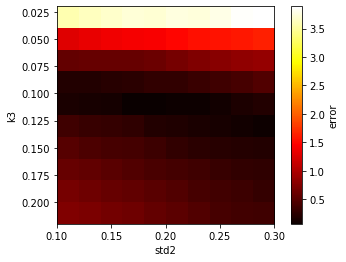

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(total_error, cmap='hot', extent=(0.10, 0.30, 0.22, 0.02))
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel('error')
ax.set_ylabel('k3')
ax.set_xlabel('std2')

In [5]:
with h5py.File('/home/TRAIN_DATA/15-10-07/whitenoise.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]
noise = single_trial - single_trial.mean(0)

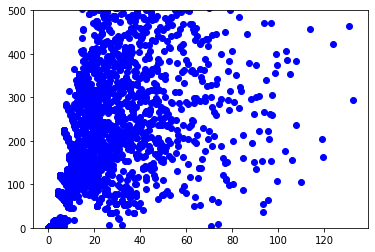

In [50]:
plt.plot(single_trial.mean(0).flatten(), noise.var(0).flatten(), 'bo')
plt.ylim(0, 500)
plt.show()

In [16]:
Fano(single_trial)

0.0718021637292504

In [11]:
single_trial_corr_matrix(5, 5, single_trial)

array([[ 1.        ,  0.00154433,  0.1219051 ,  0.0245937 , -0.03472515],
       [ 0.00154433,  1.        ,  0.07608643, -0.02250447, -0.02307129],
       [ 0.1219051 ,  0.07608643,  1.        , -0.01670914, -0.00852866],
       [ 0.0245937 , -0.02250447, -0.01670914,  1.        , -0.01350061],
       [-0.03472515, -0.02307129, -0.00852866, -0.01350061,  1.        ]])

In [6]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack_whitenoise')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.54_pearson_0.6417.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [8]:
test_data = DataLoader(TestDataset(cfg), batch_size=512)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)
test_pc

0.6023330086609981

prediction correlation: 
 [[ 1.          0.0233867   0.42233337  0.00805366 -0.0176284 ]
 [ 0.0233867   1.          0.18572387 -0.04594328 -0.05365434]
 [ 0.42233337  0.18572387  1.         -0.02189126 -0.02790954]
 [ 0.00805366 -0.04594328 -0.02189126  1.         -0.05515504]
 [-0.0176284  -0.05365434 -0.02790954 -0.05515504  1.        ]]
trial-averaged correlation: 
 [[ 1.          0.00534227  0.20452084  0.02833408 -0.0433253 ]
 [ 0.00534227  1.          0.17435322 -0.02821941 -0.03055362]
 [ 0.20452084  0.17435322  1.         -0.02448009 -0.03064869]
 [ 0.02833408 -0.02821941 -0.02448009  1.         -0.0222196 ]
 [-0.0433253  -0.03055362 -0.03064869 -0.0222196   1.        ]]
single trial correlation: 
 [[ 1.          0.00154433  0.1219051   0.0245937  -0.03472515]
 [ 0.00154433  1.          0.07608643 -0.02250447 -0.02307129]
 [ 0.1219051   0.07608643  1.         -0.01670914 -0.00852866]
 [ 0.0245937  -0.02250447 -0.01670914  1.         -0.01350061]
 [-0.03472515 -0.02307129 -0.008

Text(0.5, 1.0, 'single trial target')

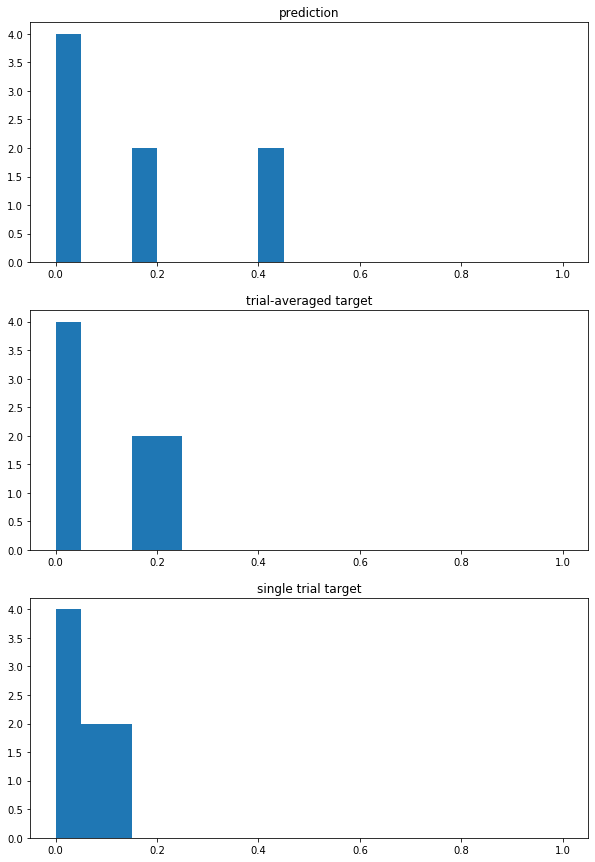

In [9]:
pred_corr, targ_corr, single_corr = correlation_matrix(pred, target, single_trial, binary=False)
print('prediction correlation: \n', pred_corr)
print('trial-averaged correlation: \n', targ_corr)
print('single trial correlation: \n', single_corr)
print('trial-averaged target prediction relative error: ', np.abs(targ_corr-pred_corr).sum()/targ_corr.sum())
print('single trial target prediction relative error: ', np.abs(single_corr-pred_corr).sum()/single_corr.sum())
fig,ax = plt.subplots(3,1,figsize=(10,15))
diagonal_idxs = [0, 6, 12, 18, 24]
ax[0].hist(np.delete(pred_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[0].set_title('prediction')
ax[1].hist(np.delete(targ_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[1].set_title('trial-averaged target')
ax[2].hist(np.delete(single_corr.flatten(), diagonal_idxs), bins=20, range=[0,1])
ax[2].set_title('single trial target')

In [10]:
error, _, fano, _, _, _ = Noises(model, test_data, single_corr, single_trial, device, poisson=[None, None, 0.1], gaussian=[0, 0, 0.18, 0])
fano_error = abs(fano - 0.0718) / 0.0718
print(error, fano, fano_error, error + fano_error)

0.060935795101941 0.091614015 0.27596121727590106 0.3368970123778421


In [13]:
n_cells = 5
with torch.no_grad():
    pred_corr = []
    pred_single_trial = []
    for n in range(10):
        val_pred = []
        val_targ = []
        for x,y in test_data:
            x = x.to(device)
            out = noise_model(x, model, device, poisson=[None, None, 0.1], gaussian=[0, 0, 0.18, 0])
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        pred_corr.append(corr_matrix(n_cells, val_pred))
        pred_single_trial.append(val_pred)
    pred_corr = np.stack(pred_corr).mean(axis=0)
    pred_single_trial = np.stack(pred_single_trial)

In [17]:
pred_corr

array([[ 1.        ,  0.01121034,  0.13527371,  0.01352639, -0.01413001],
       [ 0.01121034,  1.        ,  0.04609813, -0.01184912, -0.00760359],
       [ 0.13527371,  0.04609813,  1.        , -0.00473925, -0.00993144],
       [ 0.01352639, -0.01184912, -0.00473925,  1.        , -0.01093324],
       [-0.01413001, -0.00760359, -0.00993144, -0.01093324,  1.        ]])

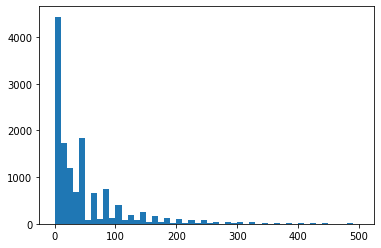

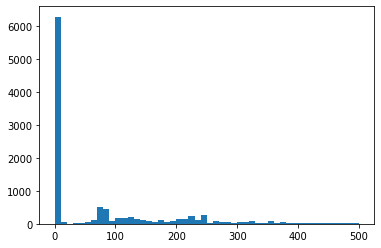

In [15]:
pred_noise = pred_single_trial - pred_single_trial.mean(0)
noise = single_trial - single_trial.mean(0)
zero_idx = np.where(pred_single_trial.mean(0).flatten() < 0.69)[0]
plt.hist(np.delete(pred_noise.var(0).flatten(), zero_idx), bins=50, range=(0,500))
plt.show()
zero_idx = np.where(single_trial.mean(0).flatten() == 0)[0]
plt.hist(np.delete(noise.var(0).flatten(), zero_idx), bins=50, range=(0,500))
plt.show()

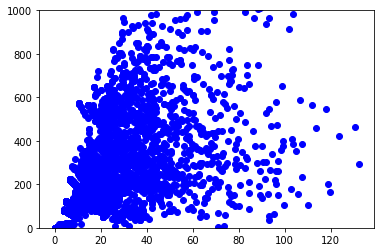

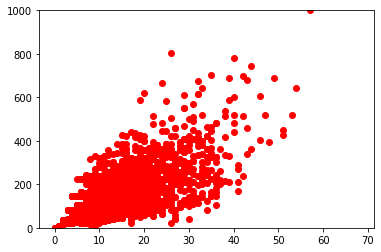

In [56]:
noise = single_trial - single_trial.mean(0)
pred_noise = pred_single_trial - pred_single_trial.mean(0)
plt.plot(single_trial.mean(0).flatten(), noise.var(0).flatten(), 'bo')
plt.ylim(0, 1000)
plt.show()
plt.plot(pred_single_trial.mean(0).flatten(), pred_noise.var(0).flatten(), 'ro')
plt.ylim(0, 1000)
plt.show()